In [1]:
import torch
from torch.utils.data import DataLoader

from torchvision.transforms import v2

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm.notebook import tqdm
import json
import numpy as np
###IE###
%load_ext autoreload
%autoreload 2
from utils.helpers import  plot_some_images ,read_images , pre_hard_skeletonize , pre_soft_skeletonize,compute_confution_matrix
from utils.preprocessing import WhiteTopHat , CLAHE , normalize_xca
from utils.dataset import  UnetDataset , ValidUnetDataset
from models.nnunet import nnUnet
from utils.losses import UnetLoss
from utils.recorder import HistoryRecorder
from logger import save_full_report
from trainer import trainer
###SS###

# Training

In [2]:
args = {
    "base_path" : "../arcade/nnUnet_dataset/syntax",
    "in_c" : 1,
    "base_channel" :32,
    "image_shape" : (512,512),
    "class_count" : 26 ,
    "attention" : True,
    "k":40,
    "batch_size" : 10,
    "num_workers" : 10,
    "device" : "cuda" if torch.cuda.is_available() else "cpu",
    "lr" : 0.001,
    "momentum" : 0.99,
    "weight_decay" : 3e-5,
    "epcohs":100,
    "f_int_scale" : 2,
    "full_report_cycle" : 10,
    "max_channels":512,
    "input_channels":1,
    "loss_type":"tversky loss",
    "alpha":0.3,
    "beta":0.7,
    "t_gamma":2.00,
    "f_gamma":2.0,
    "f_loss_scale":1,
    "loss_coefs":{"CE":1.0,"Second":1.0},
    "output_base_path" : "./outputs",
    "name" : "Attention7-DSV-tev",
    "deep_super_vision" : True,
    "f_alpha":None
}
class_map = {
    1: '1',2: '2', 3: '3',4: '4',
    5: '5',6: '6',7: '7',8: '8',
    9: '9',10: '9a',11: '10',12: '10a',
    13: '11',14: '12',15: '12a',16: '13',
    17: '14',18: '14a',19: '15',20: '16',
    21: '16a',22: '16b',23: '16c',
    24: '12b',25: '14b'
}
# losses_keys = ["total loss","FCE loss",args["loss_type"]]
losses_keys = ["total loss","CE loss",args["loss_type"]]
out_counts = 7 if args["deep_super_vision"] else 1
loss_weights = [1/(2**i) for i in range(out_counts)]
loss_weights

[1.0, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625]

In [3]:
# with open("./data/train_class_counts.json","r") as f:
#     train_class_counts = json.load(f)

# b = 0.999999

# counts = [0]*(len(train_class_counts))
# for k,v in train_class_counts.items():
#     counts[int(k)] = int(v)
# counts = np.array(counts,dtype=np.float64)

# f_alpha = (1-b)/(1-np.power(b,counts))
# f_alpha = f_alpha / f_alpha.sum()
# f_alpha[12] = 0.25
# # args["f_alpha"] = f_alpha.tolist()
# args["f_alpha"]=None
# args["f_alpha"]

In [4]:
b=0.999
train_class_counts = [
    1200,374,375,369,303,525,525,
    340,310,198,70,21,1,320,61,
    129,305,107,49,38,232,43,48,31,63,127
]
# f_alpha = (1-b)/(1-np.power(b,train_class_counts))
total = np.sum(train_class_counts)
f_alpha = np.log(total/np.array(train_class_counts))
f_alpha = (f_alpha / f_alpha.mean()).tolist()
f_alpha
args["f_alpha"] = f_alpha
f_alpha

[0.4192306623653949,
 0.7179025174767664,
 0.7172184312490237,
 0.7213506198648413,
 0.7718364322603585,
 0.6310175618202434,
 0.6310175618202434,
 0.7423200457906856,
 0.7659851796135413,
 0.8808365687040562,
 1.1472158488751967,
 1.4556618102528003,
 2.235638440011511,
 0.7578514761453713,
 1.1824730889495298,
 0.9906024194367986,
 0.7701509647332515,
 1.0385057663997224,
 1.238592452721393,
 1.3037247322439667,
 0.8402380298539683,
 1.2720560555504503,
 1.2438749107979519,
 1.3558847771047964,
 1.1742081741391486,
 0.9946054718189865]

In [5]:
# pre_soft_skeletonize(args["base_path"],output_path=args["base_path"],batch_size=10,k=40)

In [6]:
train_transforms = A.Compose([
    A.GaussianBlur(
        sigma_limit=[0.1,0.5],
        p=0.5
    ),
    A.RandomBrightnessContrast(
        brightness_limit=0.1,
        contrast_limit=0.15,
        brightness_by_max=True,
        p=0.3
    ),
    A.RandomGamma(
        gamma_limit=(90, 120), 
        p=0.3
    ),
    A.Rotate(limit=15, p=0.3 , fill_mask = 0),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.Lambda(image=normalize_xca),
    ]
)
test_transforms = A.Compose([
    A.Lambda(image=normalize_xca),
    ToTensorV2()
    ]  
)
# train_preprocess = v2.Compose([
#     WhiteTopHat(kernel_size=(50,50)),
#     CLAHE()
    
# ])
train_preprocess = None


In [7]:

train_images = read_images(base_path = args["base_path"],preprocessor = train_preprocess,part = "train")
valid_images = read_images(base_path = args["base_path"],preprocessor = train_preprocess,part = "val")

train_ds = UnetDataset(transform = train_transforms,data = train_images,base_size=args["image_shape"][0],out_counts=out_counts)
valid_ds = ValidUnetDataset(transform = test_transforms,data = valid_images)

train_loader = DataLoader(
    train_ds,
    batch_size = args["batch_size"] ,
    num_workers = args["num_workers"] ,
    pin_memory=True,
    shuffle=True
)
valid_loader = DataLoader(
    valid_ds,
    batch_size = args["batch_size"] ,
    num_workers = args["num_workers"] ,
    pin_memory=True,
    shuffle=False,
)

NOTE : preprocessor is not defined . no preprocessing will be used !


  0%|          | 0/1000 [00:00<?, ?it/s]

NOTE : preprocessor is not defined . no preprocessing will be used !


  0%|          | 0/200 [00:00<?, ?it/s]

In [8]:
# plot_some_images(train_images, train_transforms, image_counts=36, fig_shape=(6,6), base_transforms=test_transforms)

In [ ]:
model = nnUnet(args).to(args["device"])
loss_fn = UnetLoss(args)
optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])
# optimizer = torch.optim.SGD(
#     model.parameters(),
#     momentum=args["momentum"],
#     lr=args["lr"],
#     nesterov=True,
#     weight_decay=args["weight_decay"]
# )
recorder = HistoryRecorder(losses_keys=losses_keys,class_maps =class_map)

trainer(
    args=args,
    recorder = recorder,
    model = model,
    optimizer = optimizer,
    loss_fn = loss_fn,
    train_loader = train_loader,
    valid_loader = valid_loader,
    loss_weights=loss_weights)

number of layers : 7
encoder settings :  [32, 64, 128, 256, 512, 512, 512]
bottle-neck settings :  1024
decoder settings :  [1024, 1024, 512, 256, 128, 64]
head settings :  26
loss is set to tversky


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(2.4710, device='cuda:0')
--- Total Norm ---
tensor(2.1330, device='cuda:0')
train ==> epcoh (0)
total loss : 4.838445949554443 - CE loss : 2.869156849384308 - tversky loss : 1.969289138317108

train avg metrics for epoch 0 :
avg dice : 0.001876196906352548 - avg precision : 0.0022380546635758945 - avg recall : 0.006592348741360183
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (0)
total loss : 1.9037996649742126 - CE loss : 0.9131720691919327 - tversky loss : 0.99062759578228

valid avg metrics for epoch 0 :
avg dice : 4.1565164342078493e-13 - avg precision : 0.0 - avg recall : 0.0
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(1.3810, device='cuda:0')
train ==> epcoh (1)
total loss : 2.7875483322143553 - CE loss : 0.8436031693220138 - tversky loss : 1.9439451682567597

train avg metrics for epoch 1 :
avg dice : 0.001995055568555758 - avg precision : 0.011673032343387603 - avg recall : 0.0011610426290644682
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (1)
total loss : 1.3490971982479096 - CE loss : 0.378668312728405 - tversky loss : 0.9704288750886917

valid avg metrics for epoch 1 :
avg dice : 0.009896323159752567 - avg precision : 0.010205271244049073 - avg recall : 0.01714215187355876
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.3929, device='cuda:0')
--- Total Norm ---
tensor(0.8157, device='cuda:0')
--- Total Norm ---
tensor(0.6644, device='cuda:0')
train ==> epcoh (2)
total loss : 2.4250143694877626 - CE loss : 0.5708188182115554 - tversky loss : 1.8541955614089967

train avg metrics for epoch 2 :
avg dice : 0.034911680478112384 - avg precision : 0.04829295575618744 - avg recall : 0.04357249623571988
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (2)
total loss : 1.2076728999614716 - CE loss : 0.298029226064682 - tversky loss : 0.9096436589956284

valid avg metrics for epoch 2 :
avg dice : 0.05431153733323674 - avg precision : 0.06415203034877777 - avg recall : 0.06361740898340941
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(1.0493, device='cuda:0')
--- Total Norm ---
tensor(1.0383, device='cuda:0')
--- Total Norm ---
tensor(0.7113, device='cuda:0')
train ==> epcoh (3)
total loss : 2.1883440518379214 - CE loss : 0.4963226902484894 - tversky loss : 1.6920213508605957

train avg metrics for epoch 3 :
avg dice : 0.09634328246160599 - avg precision : 0.11339358150959016 - avg recall : 0.10856072813272476
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (3)
total loss : 1.1680968761444093 - CE loss : 0.3008999526500702 - tversky loss : 0.8671969383955002

valid avg metrics for epoch 3 :
avg dice : 0.08693367436567553 - avg precision : 0.1273200285434723 - avg recall : 0.09770000152289868
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (4)
total loss : 1.986343094110489 - CE loss : 0.4598442244529724 - tversky loss : 1.5264988791942598

train avg metrics for epoch 4 :
avg dice : 0.1561746322190435 - avg precision : 0.18583711951971055 - avg recall : 0.17116900139688368
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (4)
total loss : 1.0388499557971955 - CE loss : 0.26972614154219626 - tversky loss : 0.7691238075494766

valid avg metrics for epoch 4 :
avg dice : 0.1511178471035394 - avg precision : 0.18966420918703078 - avg recall : 0.16951696992618964
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (5)
total loss : 1.8592135572433472 - CE loss : 0.43210546851158144 - tversky loss : 1.4271080958843232

train avg metrics for epoch 5 :
avg dice : 0.18326668014560432 - avg precision : 0.17699320033192634 - avg recall : 0.21048069675685838
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (5)
total loss : 0.9115662187337875 - CE loss : 0.23976587429642676 - tversky loss : 0.6718003451824188

valid avg metrics for epoch 5 :
avg dice : 0.20354718887167197 - avg precision : 0.21493280693888664 - avg recall : 0.22028751505393301
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (6)
total loss : 1.758076355457306 - CE loss : 0.40756355941295624 - tversky loss : 1.3505127823352814

train avg metrics for epoch 6 :
avg dice : 0.21086462347811366 - avg precision : 0.20220693975687026 - avg recall : 0.23998051210772245
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (6)
total loss : 0.8452900558710098 - CE loss : 0.21625538989901544 - tversky loss : 0.6290346652269363

valid avg metrics for epoch 6 :
avg dice : 0.23528225436843148 - avg precision : 0.23521857351064682 - avg recall : 0.25725679710507393
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (7)
total loss : 1.6820921969413758 - CE loss : 0.3906339478492737 - tversky loss : 1.291458271741867

train avg metrics for epoch 7 :
avg dice : 0.23047623966863656 - avg precision : 0.2157250975072384 - avg recall : 0.2612223289720714
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (7)
total loss : 0.8147167891263962 - CE loss : 0.212284342199564 - tversky loss : 0.6024324491620063

valid avg metrics for epoch 7 :
avg dice : 0.25292715534603716 - avg precision : 0.25970268458127976 - avg recall : 0.2716840187460184
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (8)
total loss : 1.6383826196193696 - CE loss : 0.3804850319027901 - tversky loss : 1.2578975832462311

train avg metrics for epoch 8 :
avg dice : 0.24390418648762938 - avg precision : 0.2261677661538124 - avg recall : 0.27383066061884165
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (8)
total loss : 0.811909618973732 - CE loss : 0.2099149115383625 - tversky loss : 0.6019947081804276

valid avg metrics for epoch 8 :
avg dice : 0.2505871181193602 - avg precision : 0.2461206465959549 - avg recall : 0.27232263624668124
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (9)
total loss : 1.5597467517852783 - CE loss : 0.36372450008988383 - tversky loss : 1.196022264957428

train avg metrics for epoch 9 :
avg dice : 0.2671257442240259 - avg precision : 0.24417699933052062 - avg recall : 0.2977764627337456
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (9)
total loss : 0.7668825089931488 - CE loss : 0.20148136839270592 - tversky loss : 0.5654011413455009

valid avg metrics for epoch 9 :
avg dice : 0.2745451876524699 - avg precision : 0.2621565496921539 - avg recall : 0.3131024947762489
1 => dice : 0.7271068096160889 p : 0.7452221512794495 , r : 0.7098513245582581
2 => dice : 0.6975917816162109 p : 0.704232931137085 , r : 0.6910746693611145
3 => dice : 0.666216254234314 p : 0.6547226309776306 , r : 0.6781206130981445
4 => dice : 0.4608142673969269 p : 0.36115434765815735 , r : 0.6364384293556213
5 => dice : 0.6794334650039673 p : 0.6282616257667542 , r : 0.7396803498268127
6 => dice : 0.49432384967803955 p : 0

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.8119, device='cuda:0')


In [ ]:
# torch.save(model.state_dict(), "model.pth")

Saving Memory
Saving All Plots


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7747d40e0e00>
Traceback (most recent call last):
  File "/home/parsa/VertualEnvs/AI/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1689, in __del__
    self._shutdown_workers()
  File "/home/parsa/VertualEnvs/AI/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1653, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.12/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 1136, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/selectors.py", line 415, in select
    fd_event_list = s

  0%|          | 0/20 [00:00<?, ?it/s]

Saving Examples


  0%|          | 0/18 [00:00<?, ?it/s]

Saving Verbal Results
Copying Notebook To Results
builfding kaggle project


100%|██████████| 9/9 [00:00<00:00, 3496.55it/s]


processing ./utils/dataset.py
processing ./utils/helpers.py
processing ./logger.py
processing ./utils/preprocessing.py
processing ./utils/recorder.py
processing ./models/nnunet_blocks.py
processing ./models/nnunet.py
processing ./utils/losses.py
processing ./trainer.py


100%|██████████| 1/1 [00:00<00:00,  6.11it/s]

processing ./temp_script.py


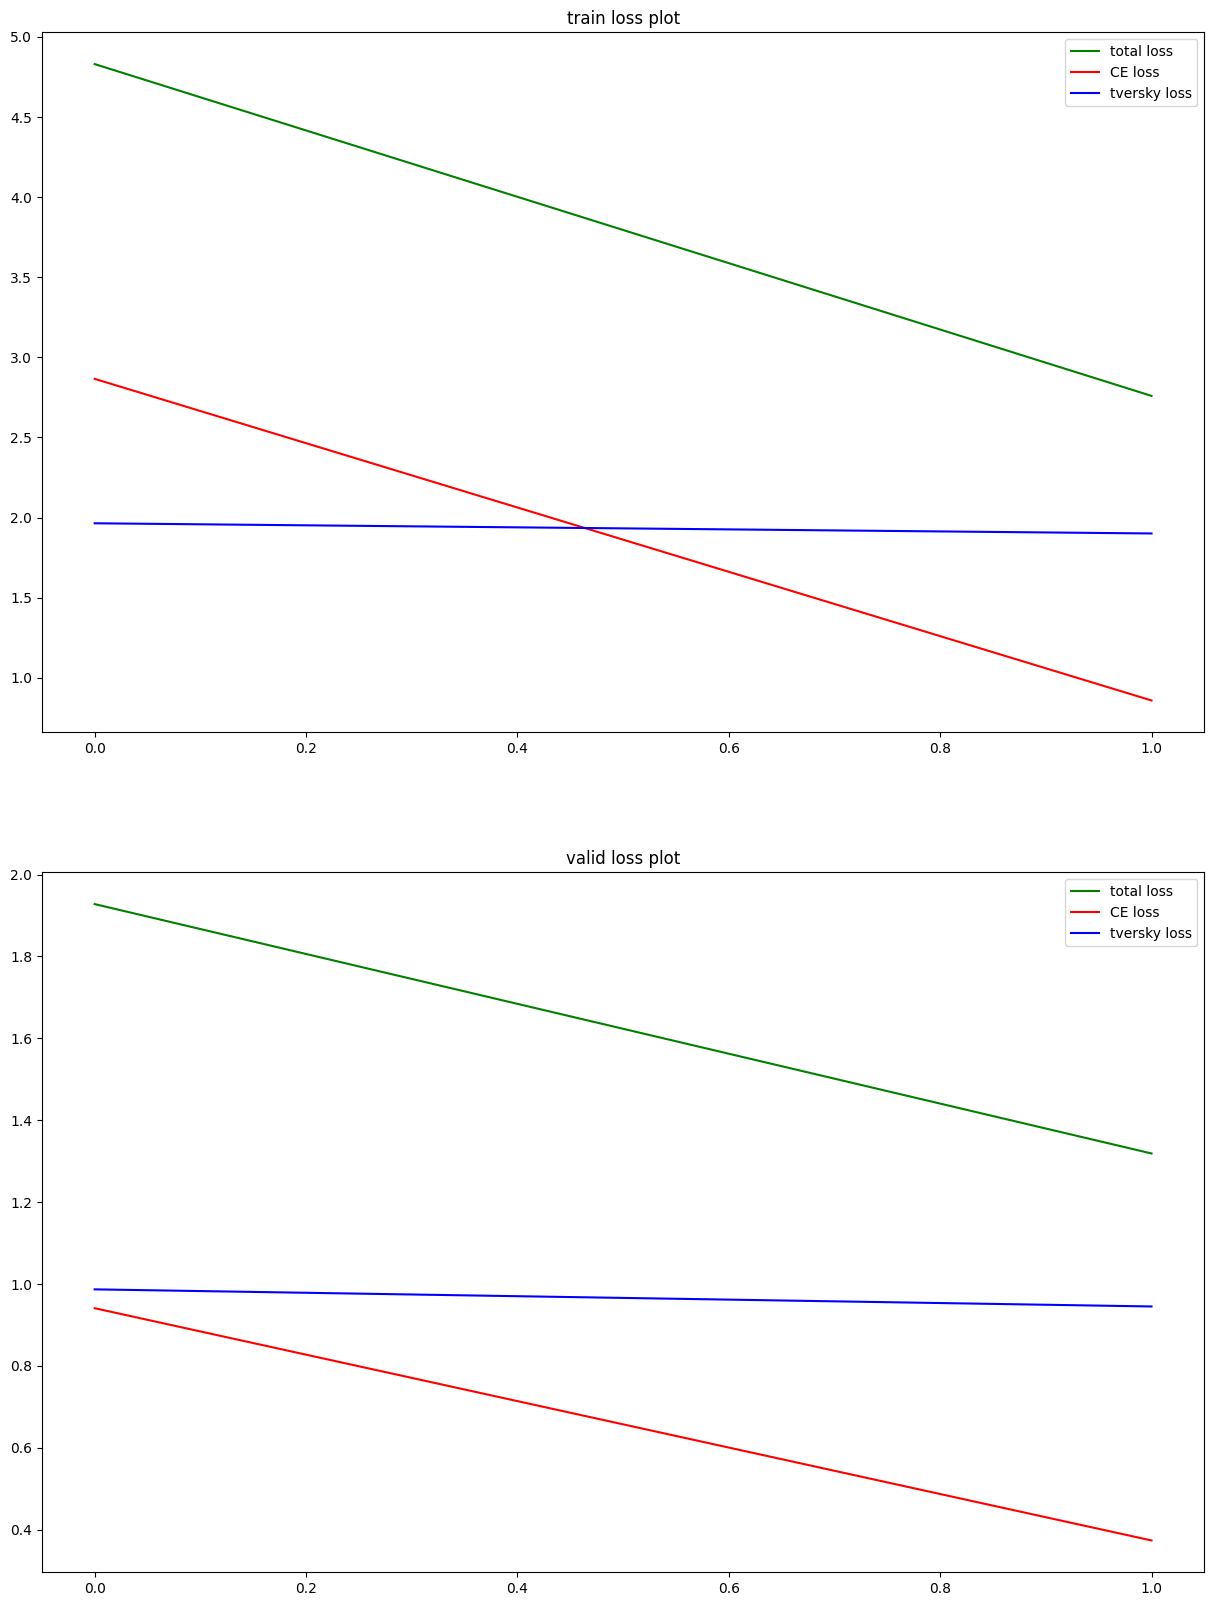

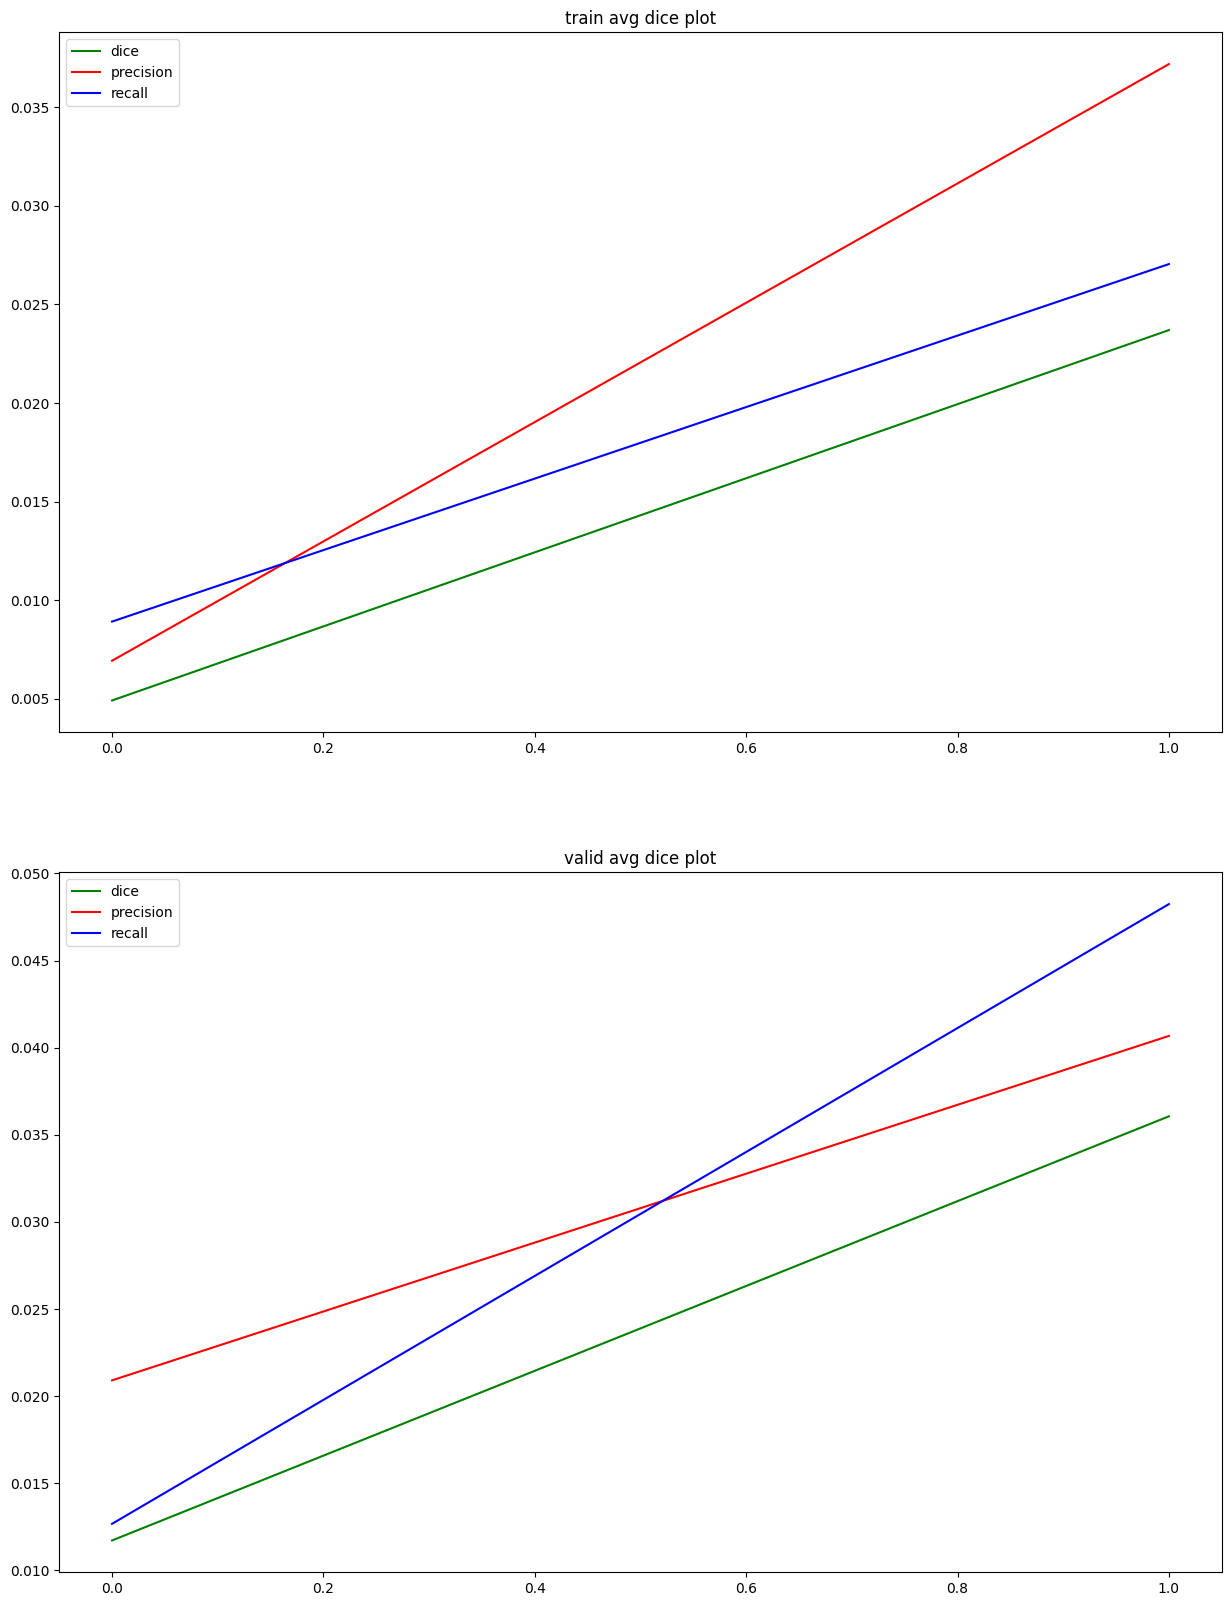

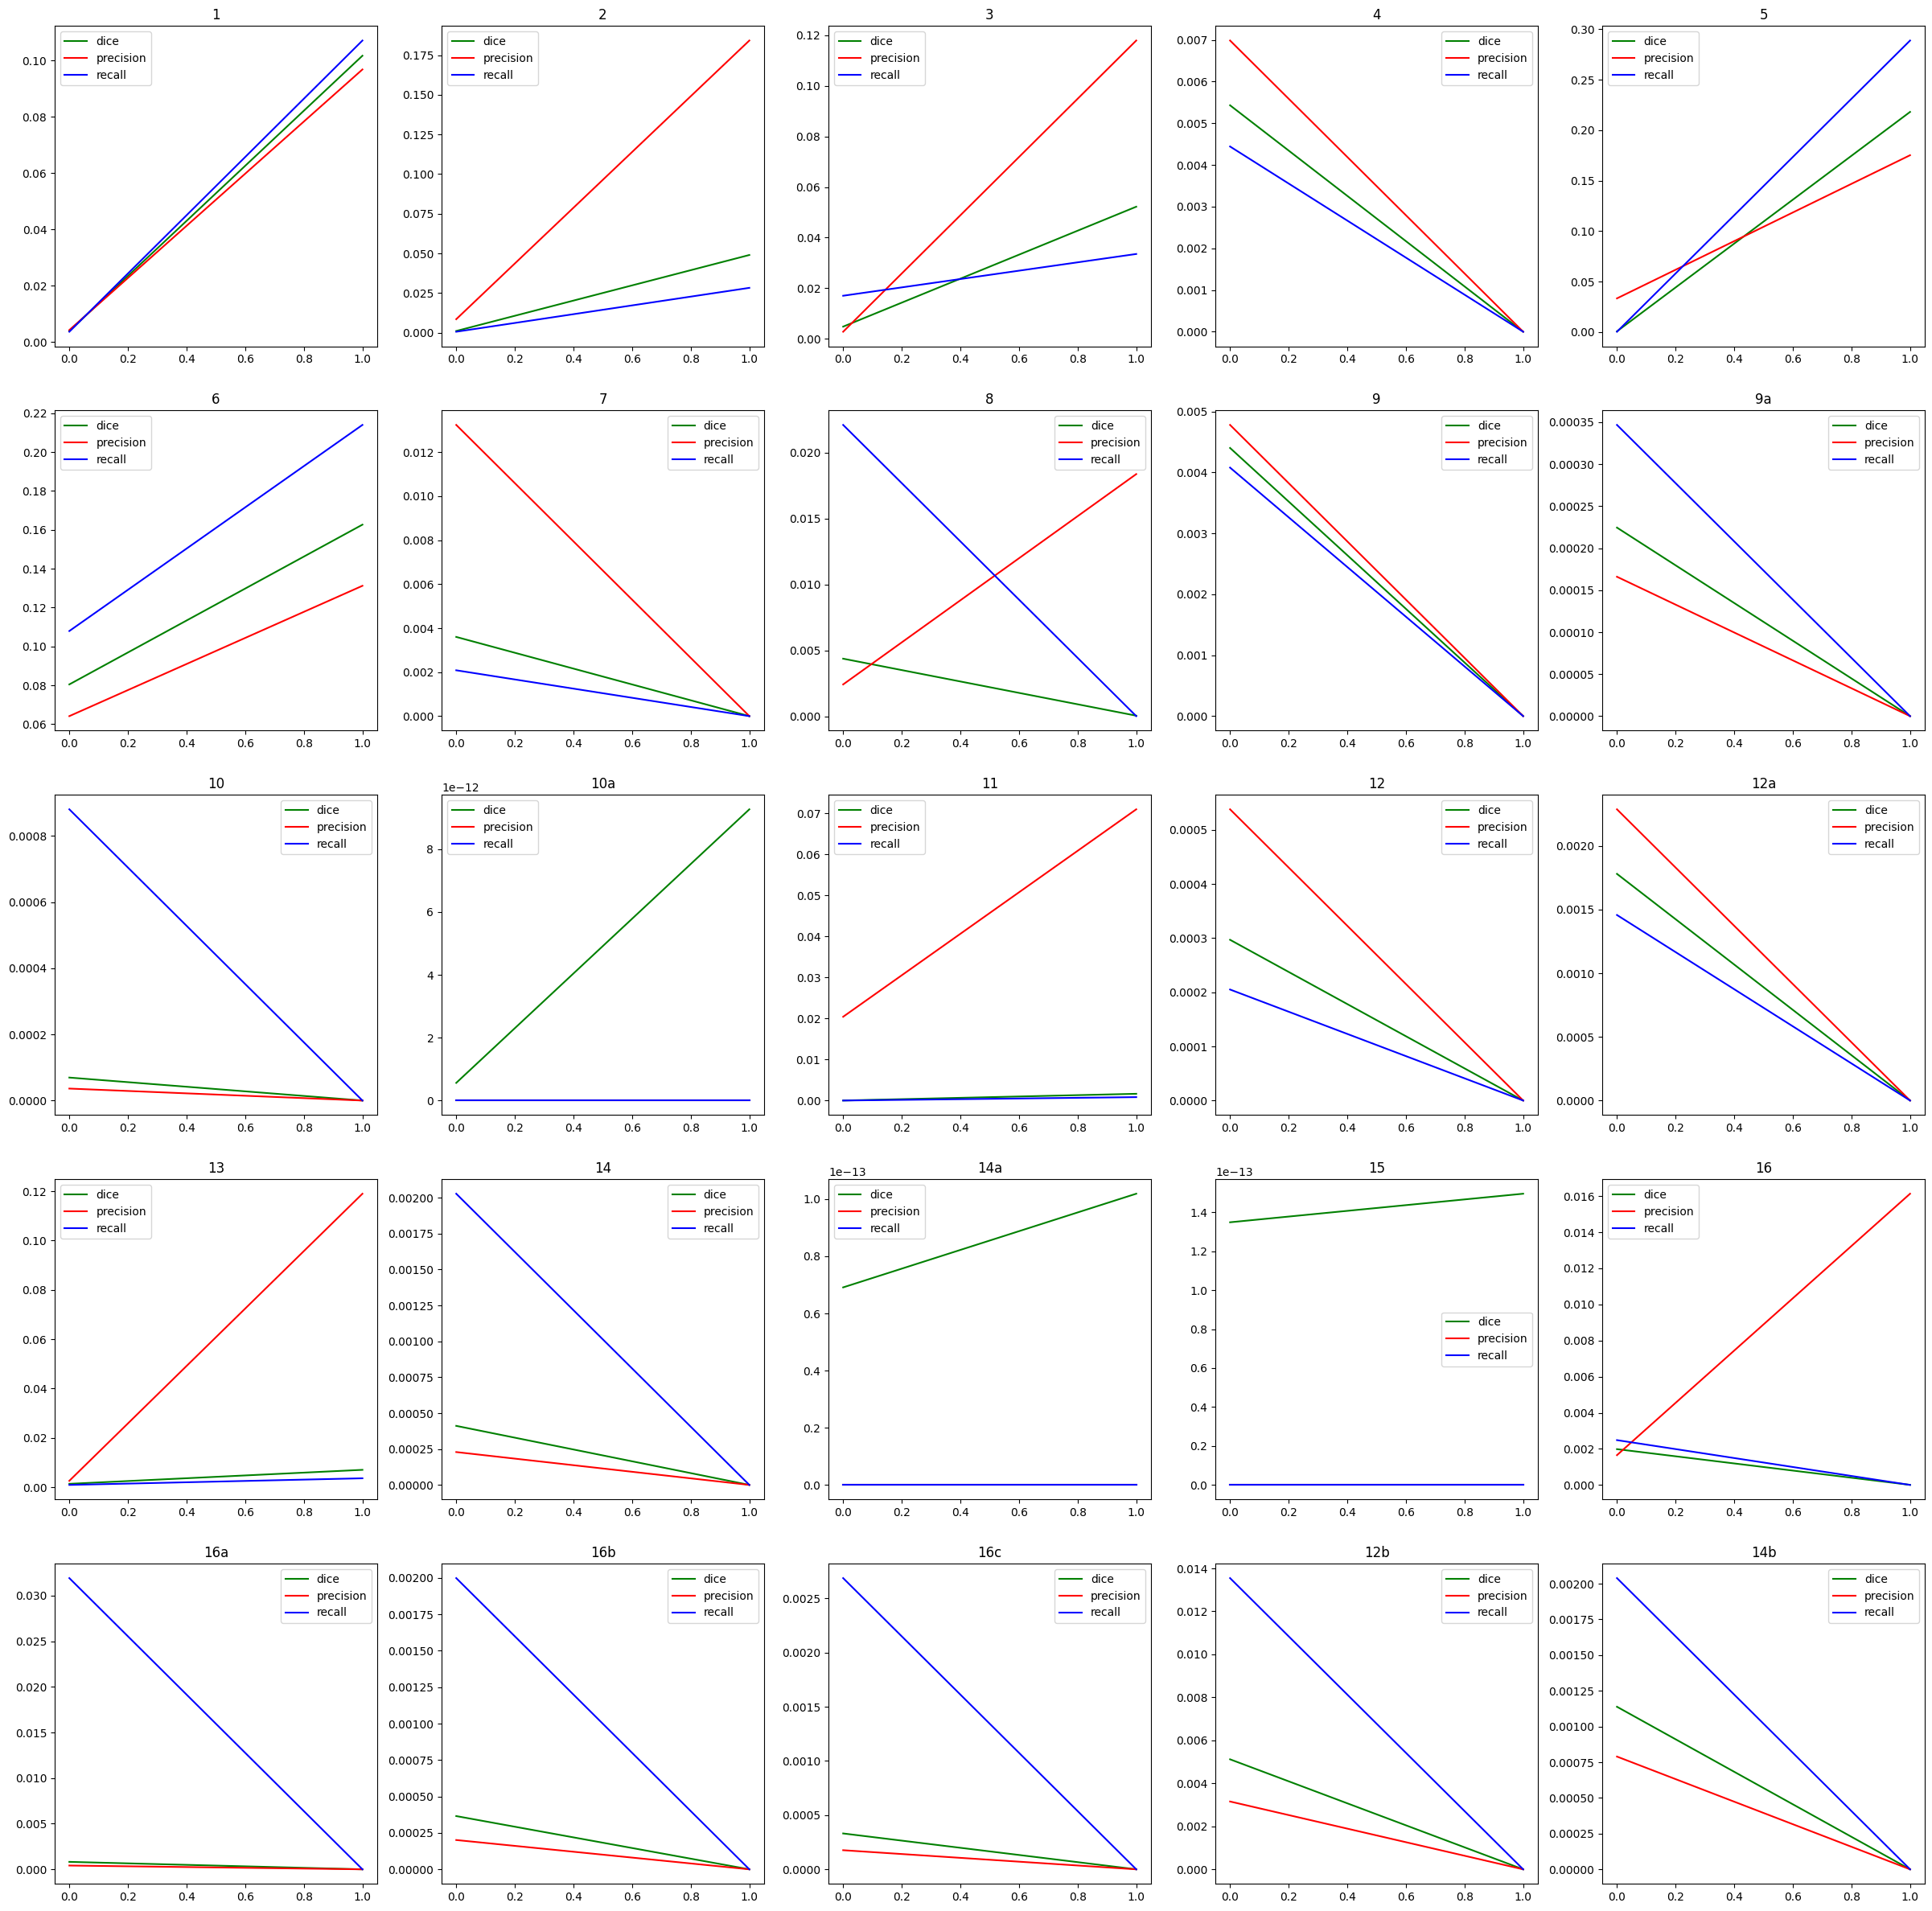

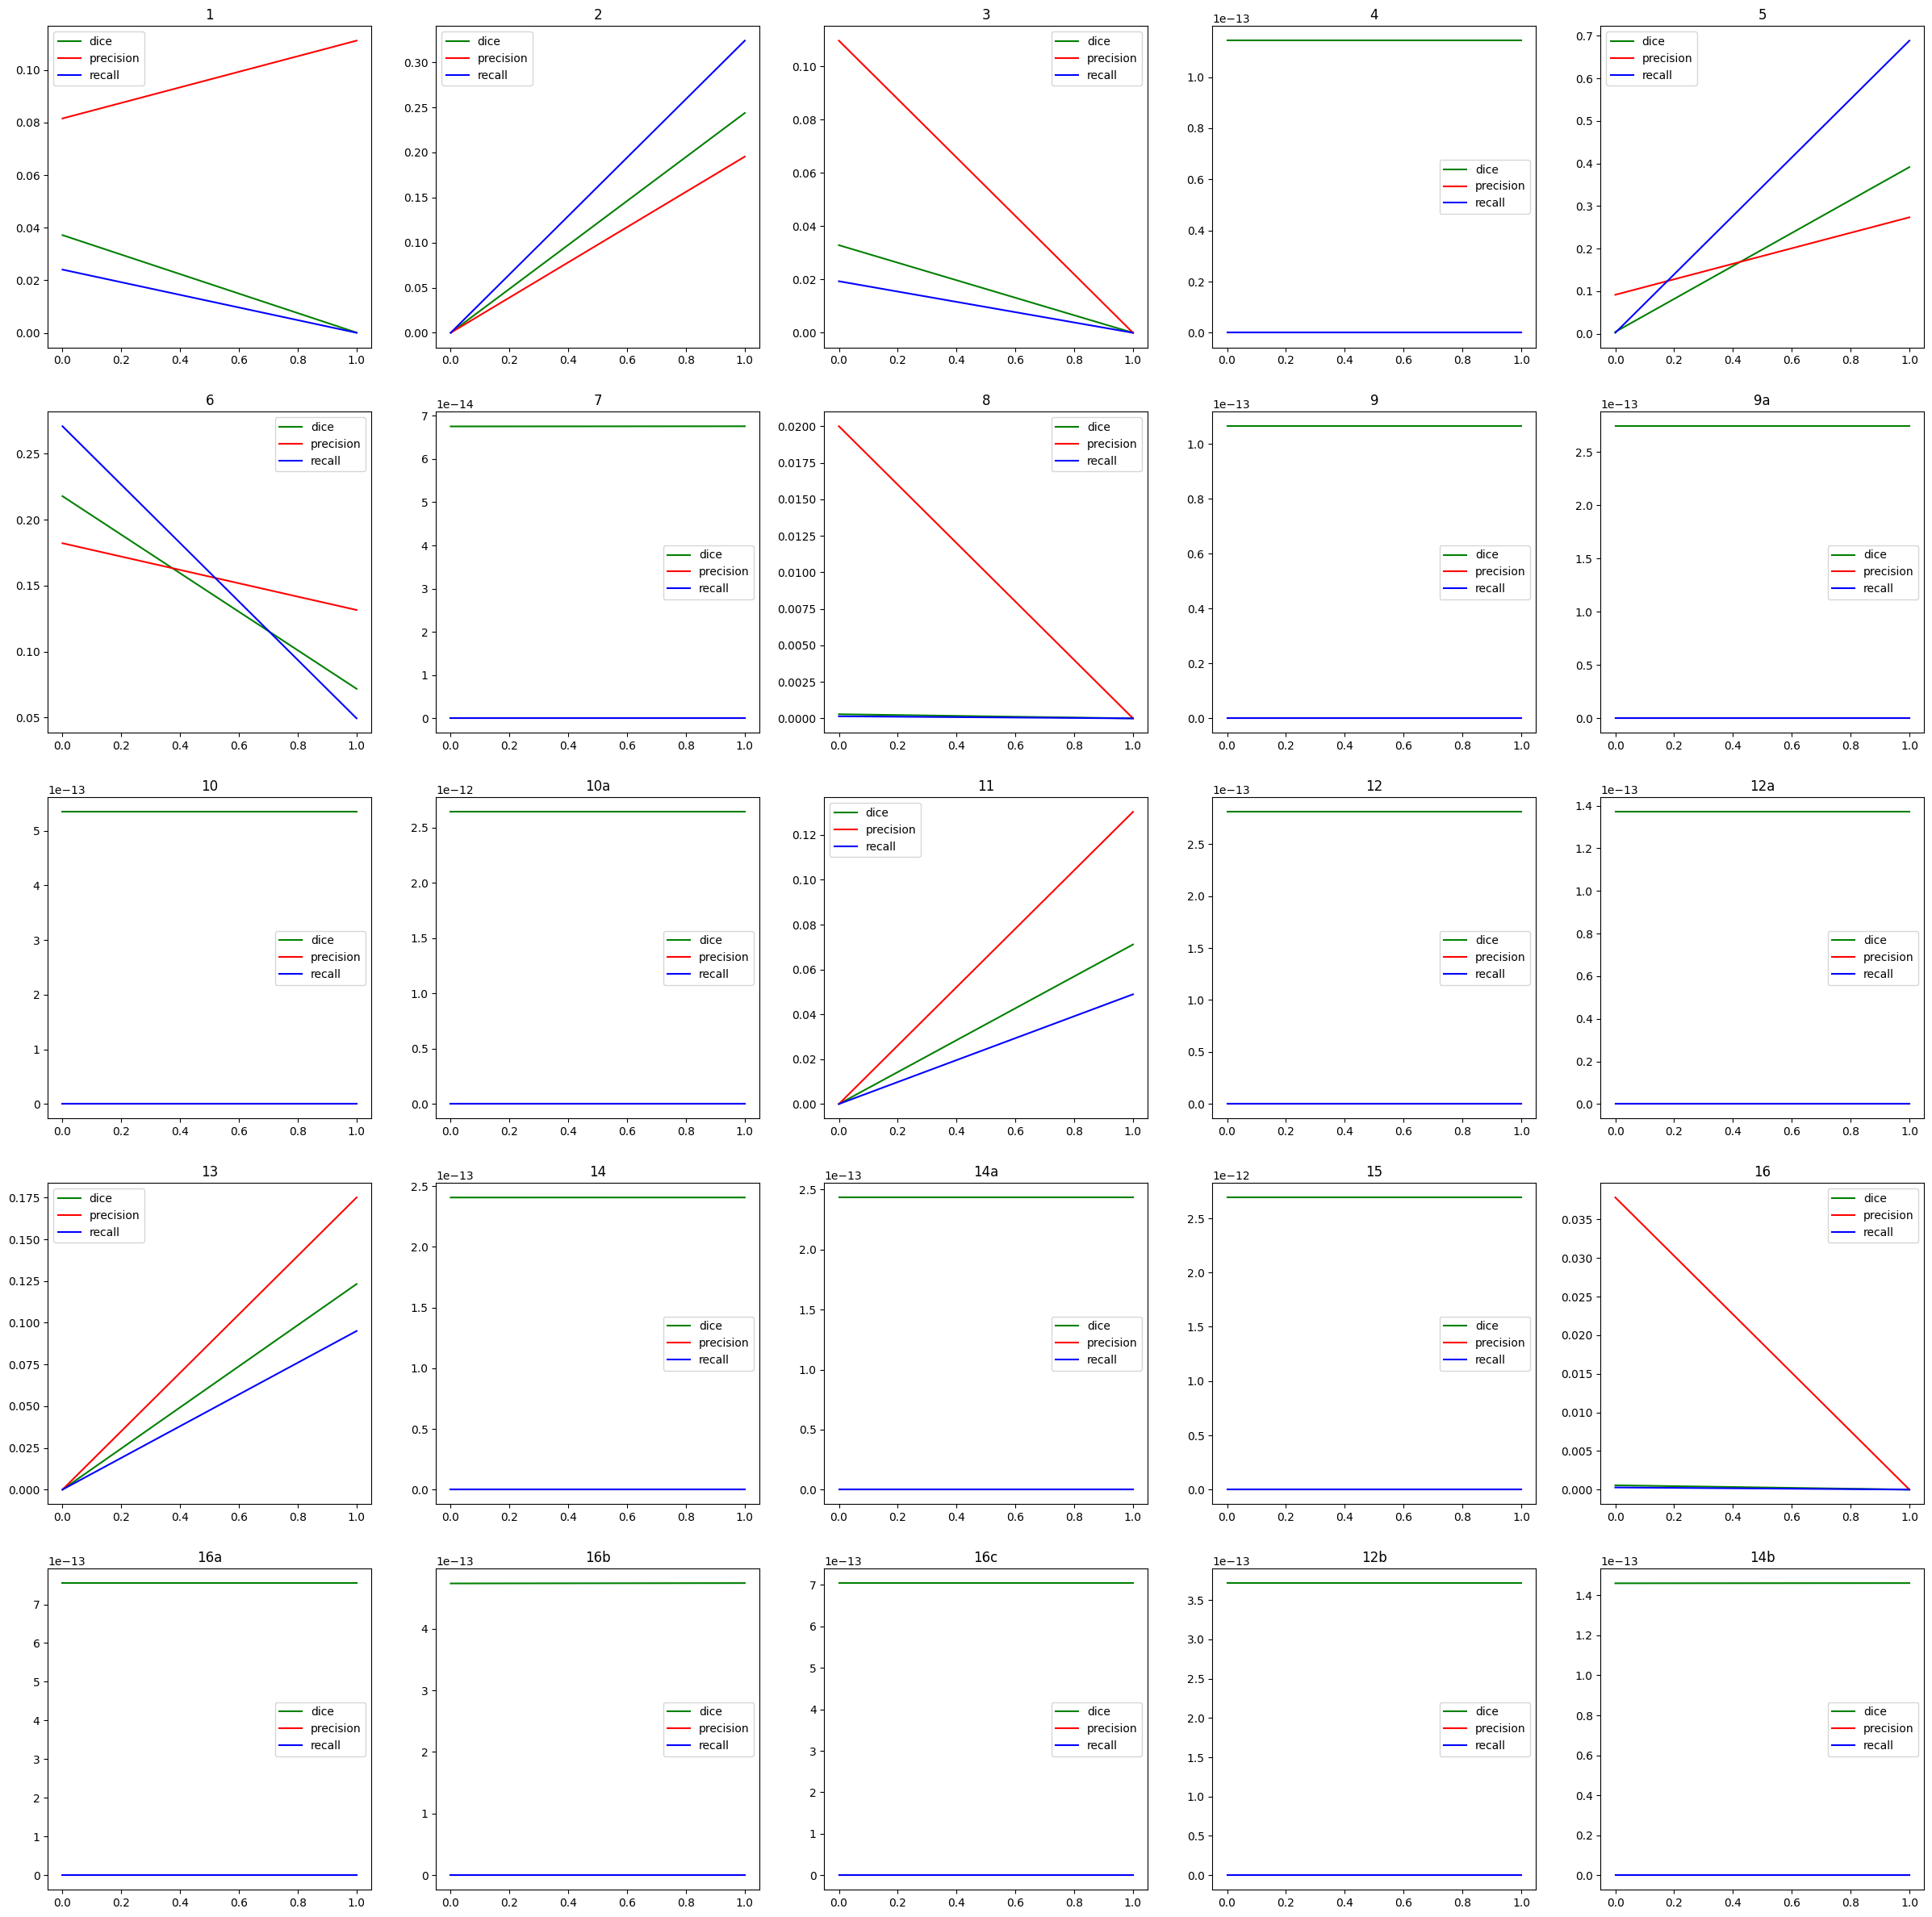

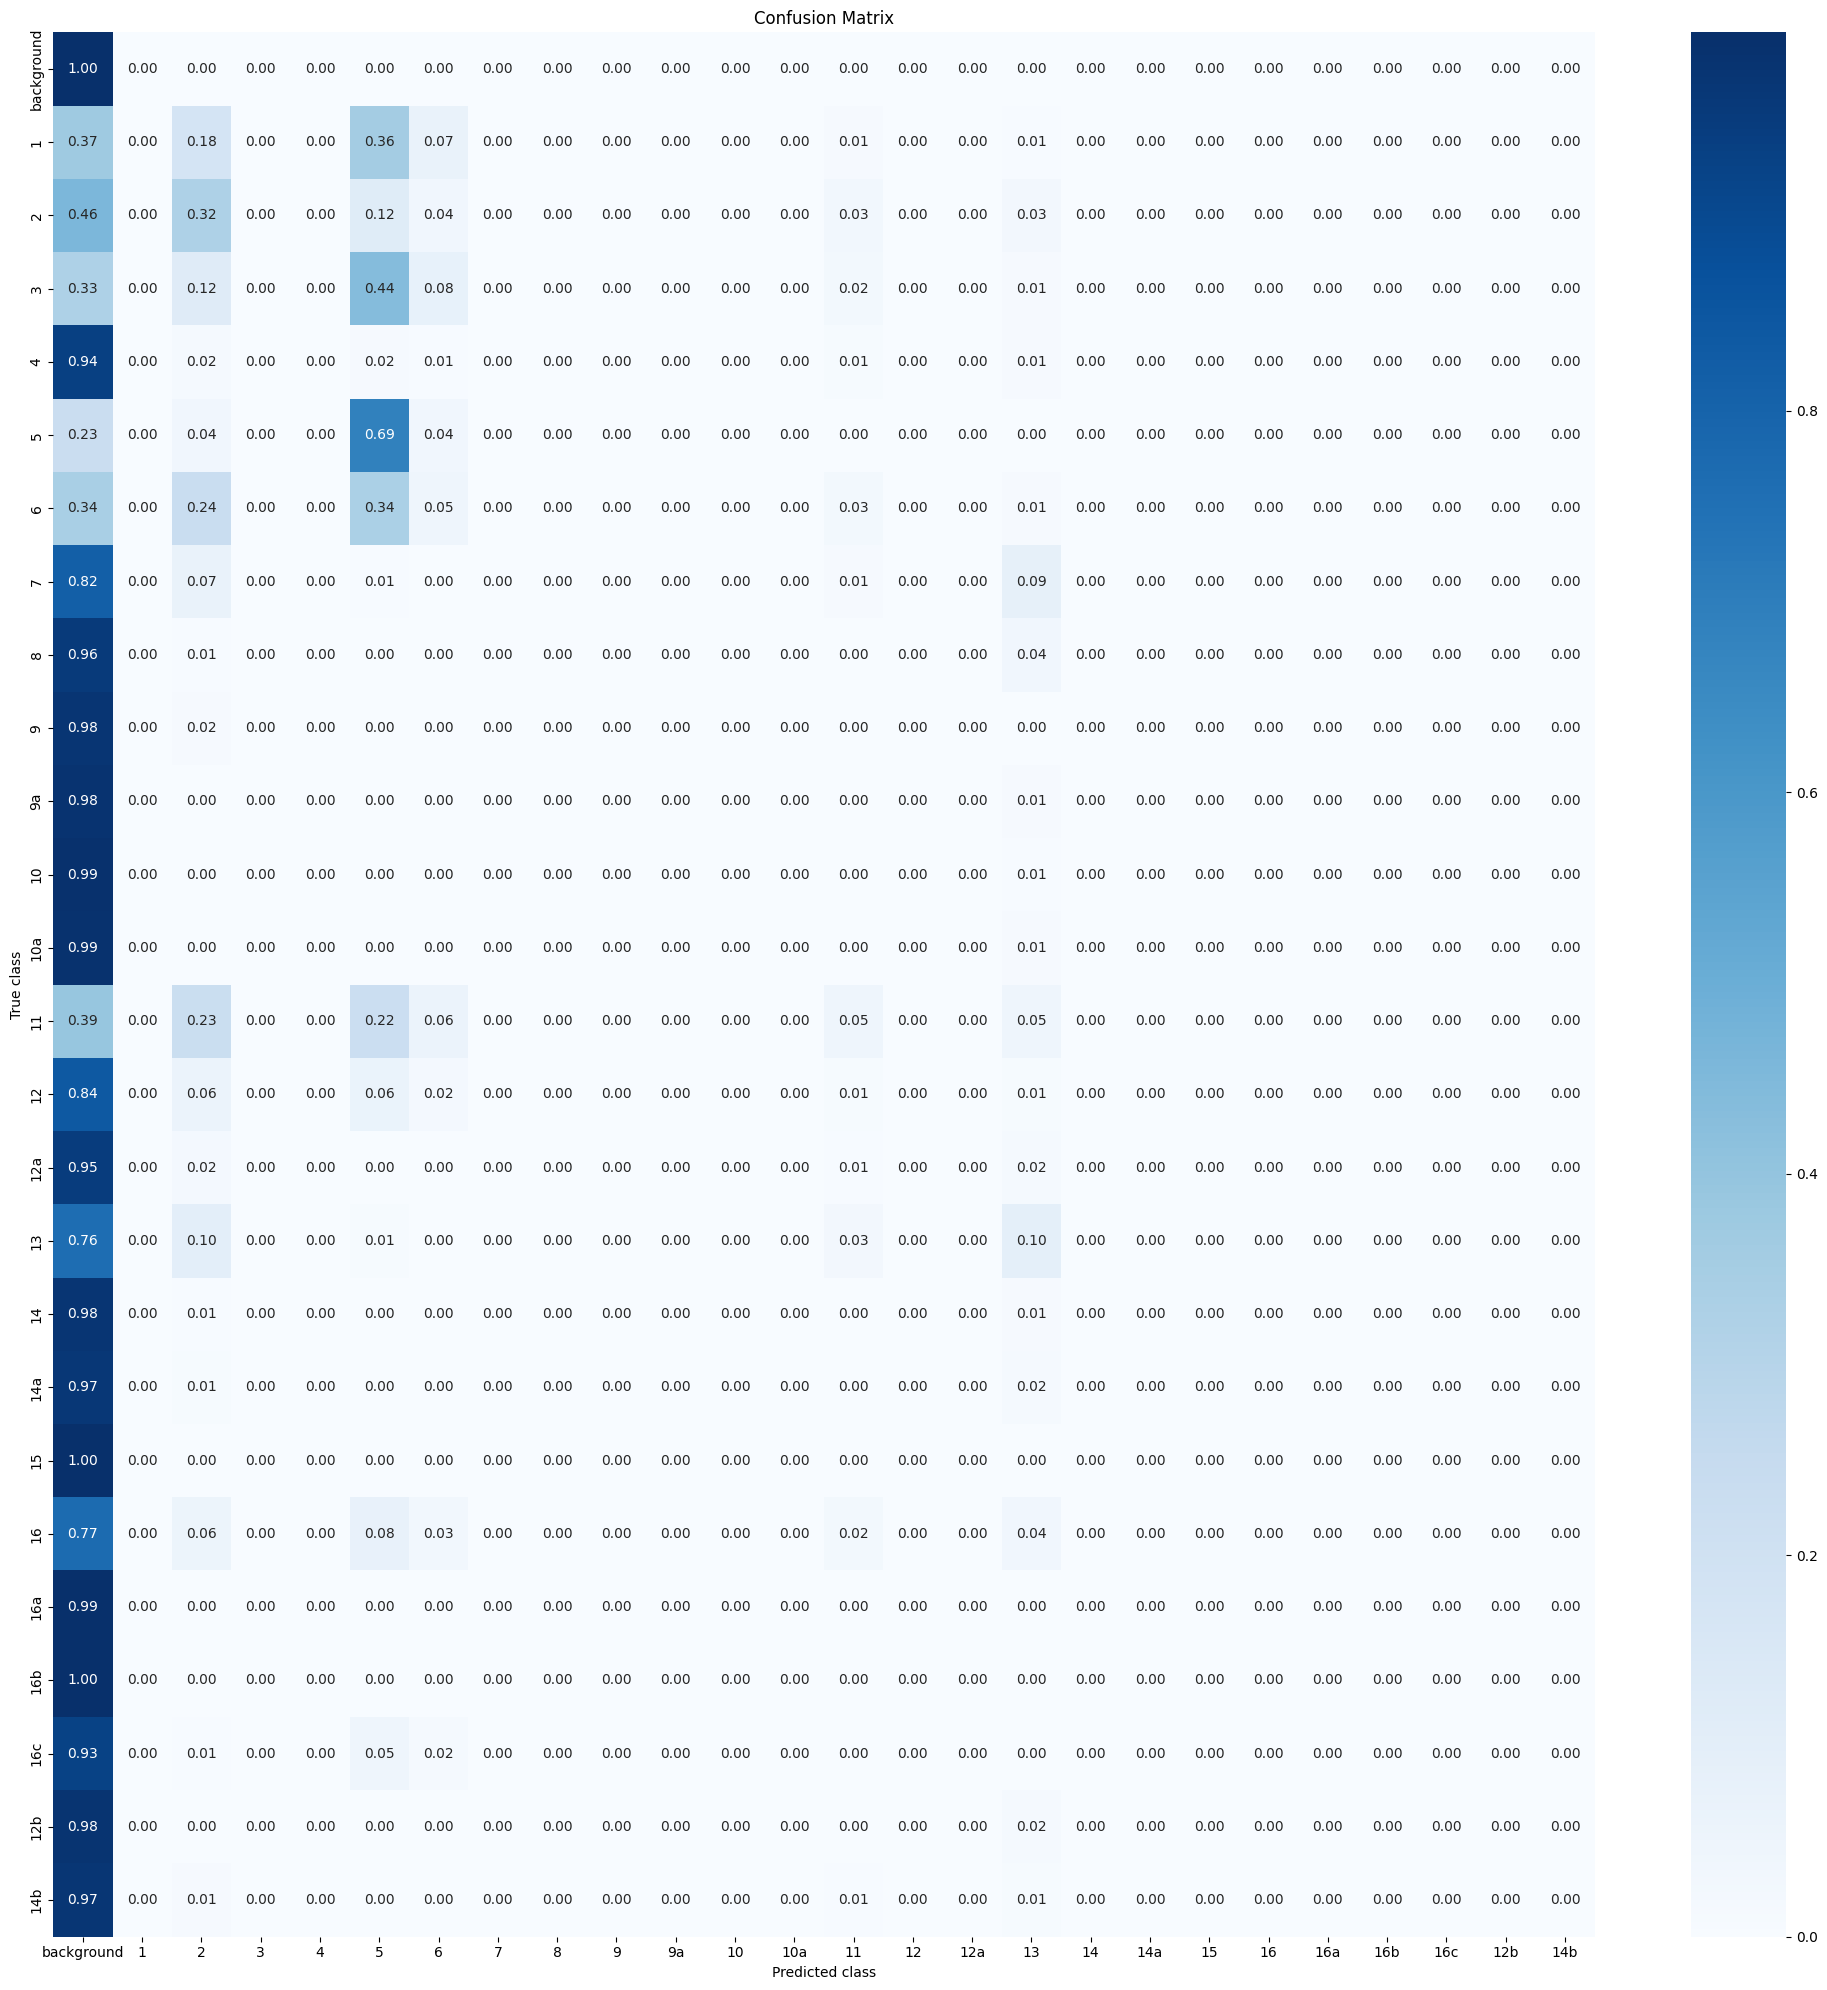

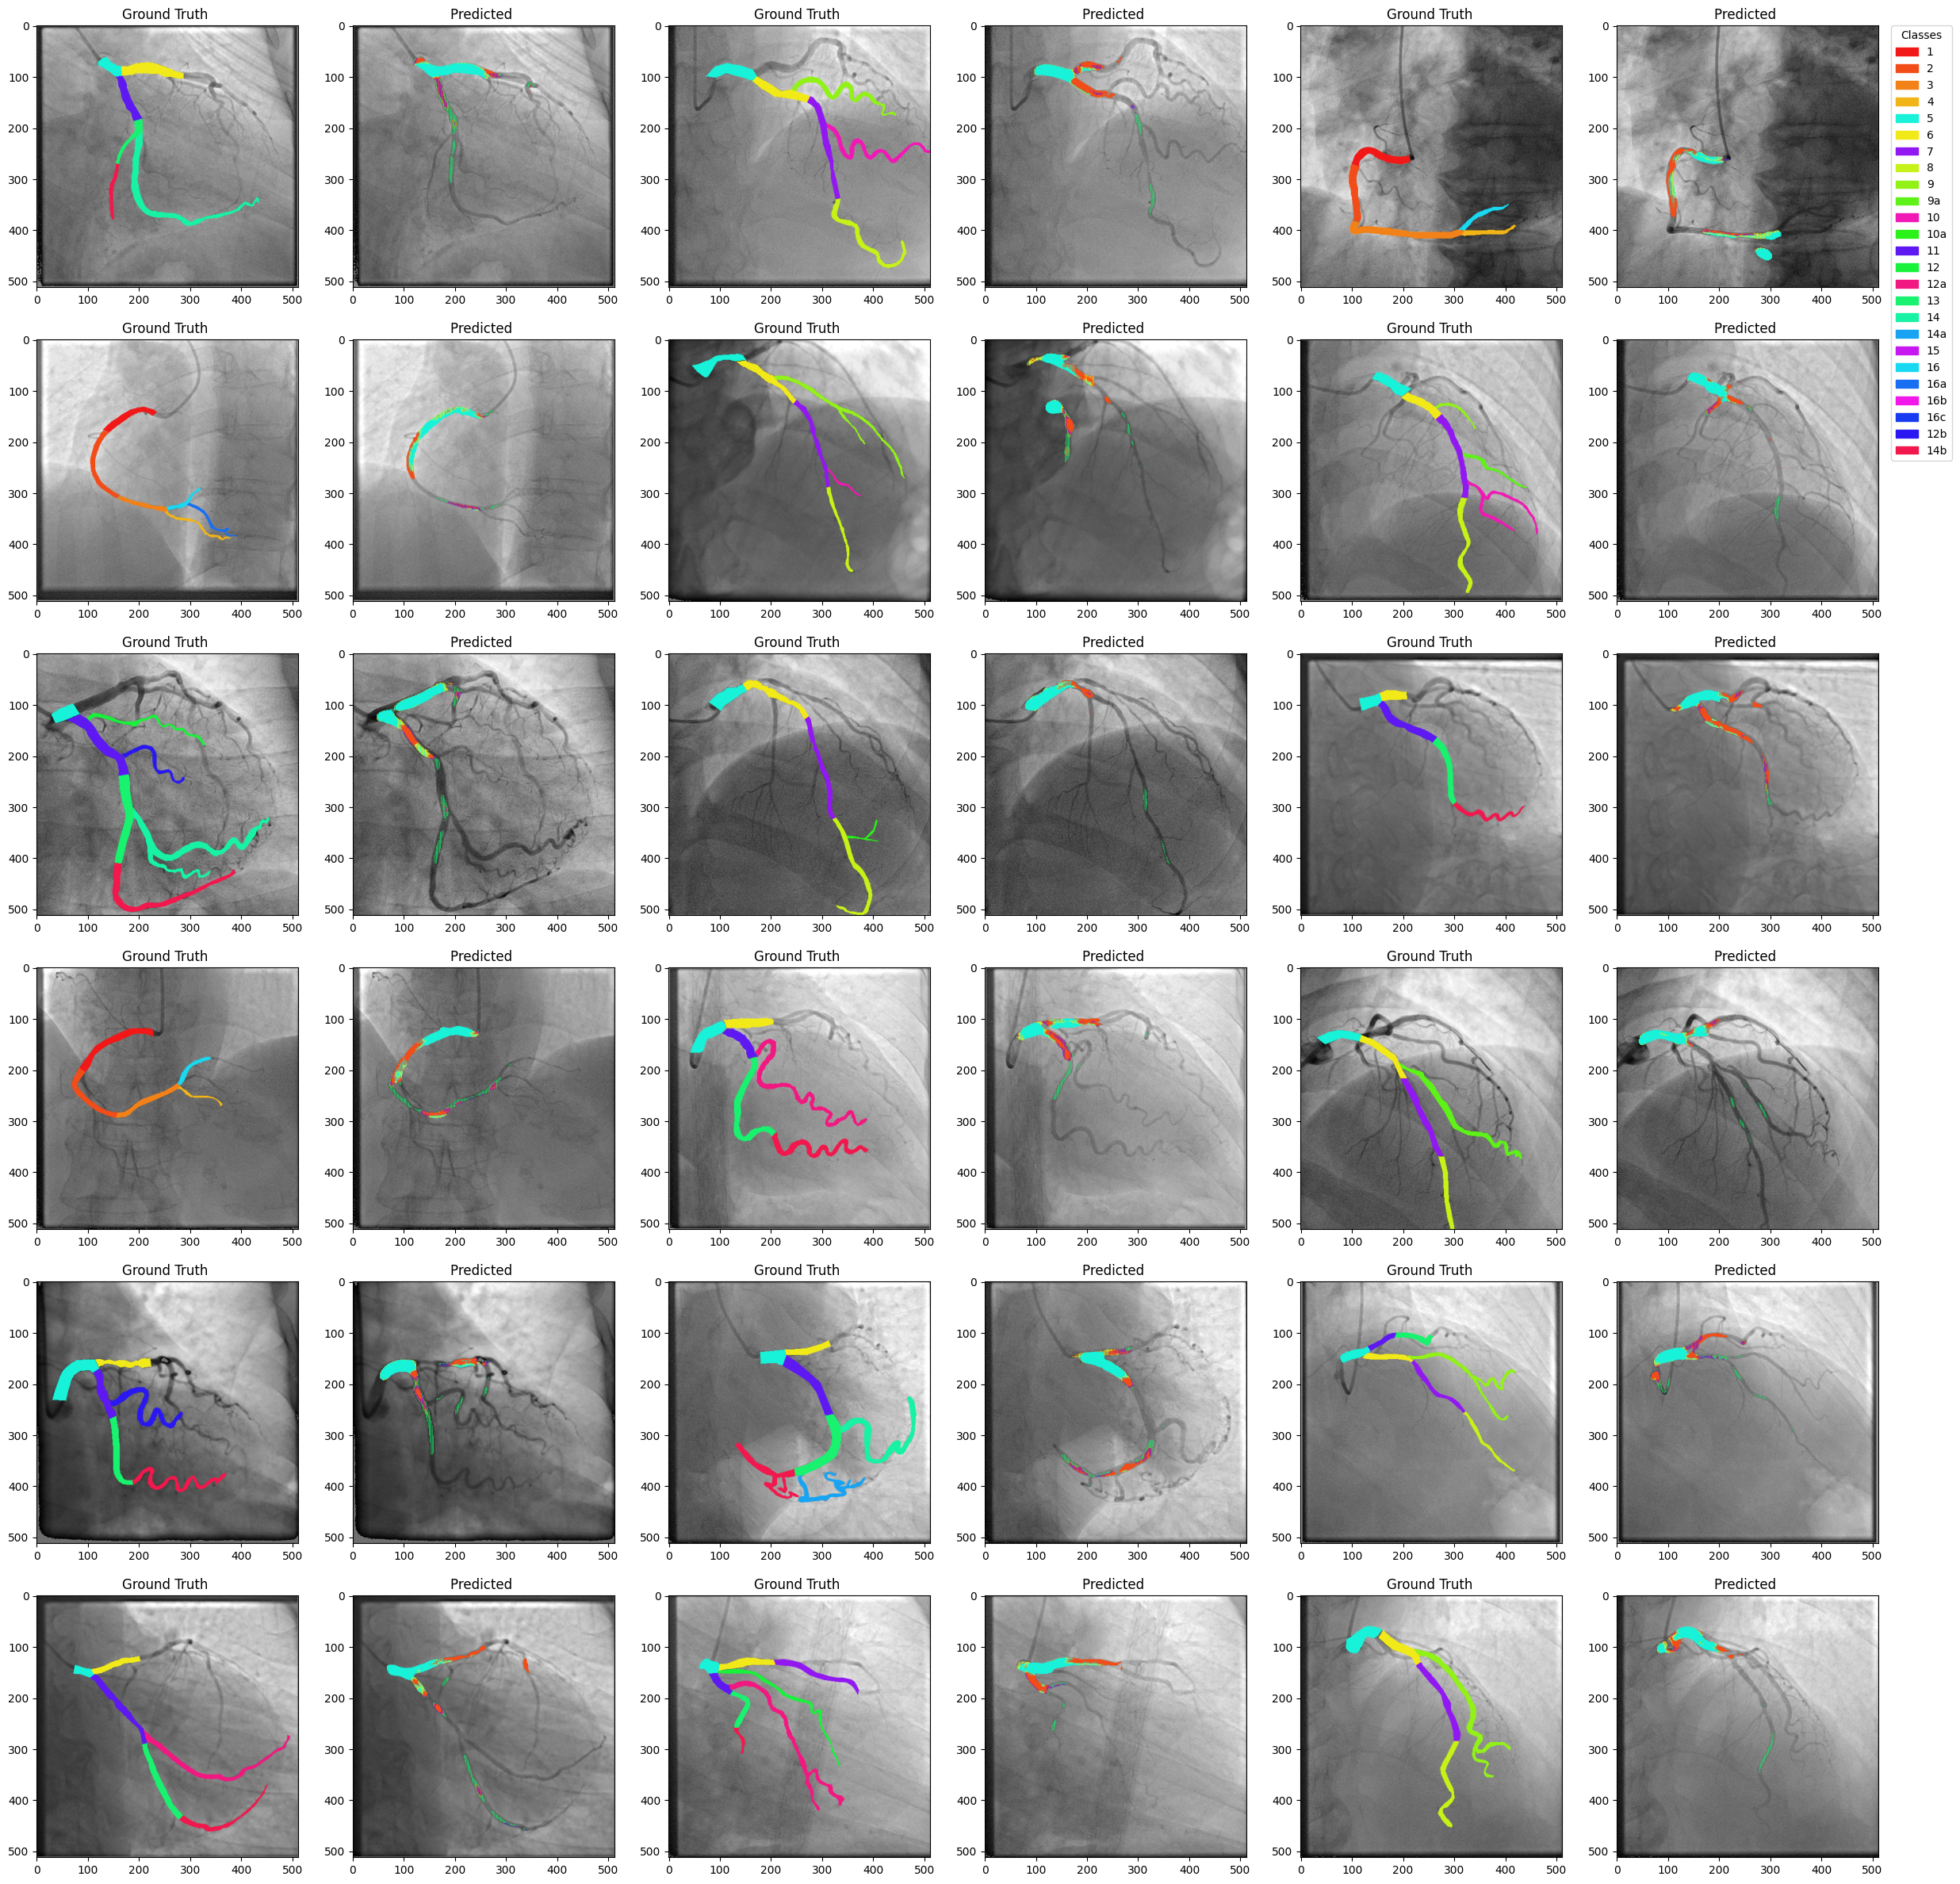

In [ ]:
save_full_report(
    recorder= recorder , 
    output_base_path=args["output_base_path"],
    model=model,
    valid_loader=valid_loader,
    args=args,
    class_map=class_map,
    name=args["name"]
)